# Machine Learning Tutorial

**Tutorial Lead:** Sean Foley (NASA, MSU)

<div class="alert alert-success" role="alert">

The following notebooks are **prerequisites** for this tutorial:

- [Earthdata Cloud Access](../earthdata_cloud_access)

</div>

## Summary

This tutorial will walk you through a simple machine learning pipeline. We will apply some basic supervised learning techniques to the task of cloud masking in PACE data.

## Learning Objectives

At the end of this notebook you will know:

- How to construct a simple machine learning dataset in Pytorch
- The meaning of training, validation, and test sets
- How to construct a simple neural network in Pytorch
- How the backpropagation algorithm works
- How to construct a training loop in Pytorch
  
Stretch goals:
- How to use a GPU to speed up training
- How to use a convolutional neural network to process images better and faster
- How to augment your training data to improve generalization

## Contents

1. [Setup](#1.-Setup)
2. [Cloud Masking](#2.-Cloud-Masking)
3. [Training, Validation, and Test Sets](#3.-Training,-Validation,-and-Test-Sets)
4. [Datasets and DataLoaders](#4.-Datasets-and-DataLoaders)
5. [A Simple Multi-Layer Perceptron](#5.-A-Simple-Multi-Layer-Perceptron)
6. [Optimization](#6.-Optimization)
7. [A Minimal Training Loop](#7.-A-Minimal-Training-Loop)
8. [Running on GPU/CUDA](#8.-Running-on-GPU-/-CUDA)
9. [Convolutional Neural Networks](#9.-Convolutional-Neural-Networks)
10. [Putting It All Together](#10.-Putting-It-All-Together)
11. [Want More?](#11.-Want-More?)

## 1. Setup

As usual, we will begin by importing some libraries. Some of the more notable ones include:
- matplotlib: This is the most common plotting library in python
- numpy: For efficient array operations on CPU
- PIL: Python Image Library, aka Pillow, will let us easily open image files.
- torch: Short for [Pytorch](https://pytorch.org/), this is the machine learning library of choice for this tutorial. This is the most popular machine learning library among researchers as it represents a good balance between flexibility and ease-of-use.
- tqdm: For progress bars on loops

In [1]:
from functools import cache
import json
import pathlib

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

CLDMASK_PATH = pathlib.Path('/home/jovyan/shared/pace-hackweek-2024/cldmask_dataset')

[back to top](#Contents)

## 2. Cloud Masking

Cloud masking refers to the task of assigning a binary value to each pixel in a satellite image, according to whether or not that location is covered by a cloud. It is essential to many other data products. For non-atmospheric scientists, this is usually useful to know what pixels to ignore, or 'mask out', in processing. For atmospheric scientists, it is often the opposite: we may exclusively wish to study the clouds.

The cloud mask data we will use today comes from the PACE data, and is itself already the product of a machine learning algorithm. Normally, you wouldn't recreate the output of a machine learning algorithm with another machine learning algorithm (that takes the exact same inputs), but this will serve fine for the purposes of our tutorial.

We have pre-processed the cloud mask data and associated OCI imagery into an easy-to-use dataset. We have taken OCI granules and chopped them up into 64x64 patches. The inputs include 11 of the OCI bands from the visible to the near-infrared: 413, 442, 470, 550, 650, 865, 940, 1249, 1378, 1618, and 2131 nm. The inputs also include a land vs. sea mask, which will be useful information for our model. The output is the binary cloud mask. Since there are 12 inputs, we have split each image into 3-channel groups to be able to save them as PNG files. Along with the inputs and output, we include the associated validity mask, which indicates whether each pixel is valid for processing. These files are all already stored here on the server, located in the path specified above in the CLDMASK_PATH variable.

Let's look at an example. The next cell will open and display the images for a single instance.

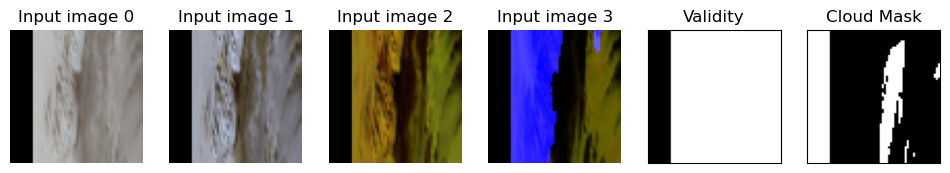

In [2]:
ex_img_idx = 57  # this image index displays a meaningful cloud mask and 
input_imgs = [Image.open(CLDMASK_PATH / 'input' / f'{ex_img_idx:07d}_{i}.png') for i in range(4)]
validity = Image.open(CLDMASK_PATH / 'input' / f'{ex_img_idx:07d}_mask.png')
cld_mask = Image.open(CLDMASK_PATH / 'output' / f'{ex_img_idx:07d}.png')

fig, axs = plt.subplots(1, 6, figsize=(12, 2))
for i in range(4):
    axs[i].imshow(input_imgs[i])
    axs[i].axis('off')
    axs[i].set_title(f'Input image {i}')
axs[4].imshow(validity)
axs[5].imshow(cld_mask)
axs[4].set_title('Validity')
axs[5].set_title('Cloud Mask')
for i in [4, 5]:
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

Take note of a few things:
- On the left of the images, there is a black strip. This patch partially extends past the edge of the sensor swath. Note that the validity mask indicates that these pixels should be discarded.
- The colors appear quite different between the four input images. These bands capture quite a diversity of information about the scene.
- The strong blue feature in input image 3 indicates the land-sea mask.
- The cloud mask is positive where there are NOT clouds. We can invert this later.

So, how many instances are there in this dataset? Let's find out:

In [3]:
len(list((CLDMASK_PATH / 'output').glob('*.png')))

241743

Wow! That's a lot. And this represents a small fraction of the available data since PACE has launched. With PACE, we truly are drowning in data. This is why machine learning is such a valuable tool for us. Next, let's talk about how we're going to use that data.

[back to top](#Contents)

## 3. Training, Validation, and Test Sets

When training a machine learning algorithm, it's important to understand how your model generalizes to data it hasn't been directly trained on. It's also important to understand how your particular choices of designing that model will generalize to data that you haven't tuned those choices for. For that reason, it is standard practice to divide your data into a training, validation, and test sets. The purpose of the training set is to fit your model. Your model will be directly supervised on that data. The purpose of the validation set is to allow you to figure out how to improve your model's design. The model parameters should NOT be fit to the validation data. Your hyperparameters (e.g. how many layers in your neural network, the learning rate, the type of data augmentation) are optimized with respect to the validation set. In other words, while you're making decisions about how to design your model, the validation set is what you base those decisions on. Finally, the test set is the last thing you use. You shouldn't make any changes (to parameters or hyperparameters) after seeing your results on the test set. Oftentimes, the maintainers of benchmark datasets will not provide labels for the testing set. To get their results, participants will send their predictions to maintainers of the benchmark, who will themselves evaluate the results.

To recap, the training set is for fitting parameters, the validation set is for fitting hyperparameters, and the test set is for fitting NOTHING. You can split up your data in lots of different ways, but you typically want your training set to be the largest set, allowing your model to see the greatest diversity of data possible. The validation and test set should only be as big as is necessary to give you an accurate evaluation of your model.

**NOTE:** Normally, you want to make sure you're not accidentally "cheating" by sampling your train/val/test from the same distribution. For example, you wouldn't want the same granule to yield patches in two different sets. You might want to enforce even stricter requirements on your splits, like having a test set from a different season than the rest of your data, to show that your method generalizes to any time of year. For simplicity's sake, we will be ignoring these good practices, and sampling our patches randomly, regardless of what granule they're from.

Another common practice which we will ignore is called "cross validation", where you generate multiple train/val splits, fitting your model independently to each one, to get an understanding of the variance between different splits of the data.

`generate_split` will generate a random training/validation/test "split" and save it to a JSON file. Go ahead and run it. Careful, as if you've already run this function before with the same split name, it will throw a ValueError, unless you add "replace=True" to the function call.

In [4]:
def generate_split(name: str, replace: bool = False) -> None:
    """Generate a train/val/test split, replacing an existing split with the same name only if specified.

    Args:
        name: The name of the split file to generate.
        replace: Whether to replace an existing split file with the provided name.
    """
    # count how many images are available in the data
    num_imgs = len(list((CLDMASK_PATH / 'output').glob('*.png')))
    
    # determine how many images are in the train, val, and test data, using a 70%, 15%, 15% split
    num_train = round(0.7 * num_imgs)
    num_val = round(0.15 * num_imgs)
    num_test = round(0.15 * num_imgs)
    
    # fix any rounding errors
    num_train += num_imgs - (num_train + num_val + num_test)
    
    # get an array of image indices, shuffle it, and assign indices to train/val/test
    img_idxs = np.arange(num_imgs)
    np.random.shuffle(img_idxs)
    split = {
        'train': sorted(img_idxs[:num_train].tolist()),
        'val': sorted(img_idxs[num_train:num_train + num_val].tolist()),
        'test': sorted(img_idxs[-num_test:].tolist()),
    }

    split_path =  pathlib.Path(f'{name}.json')
    if not replace and split_path.exists():
        raise ValueError(f"Uh oh, you tried to create a split called '{name}', but '{split_path}' already exists. \
                         Please either choose a different name or pass 'replace=True' to this function.")

    json.dump(split, open(split_path, 'w'))

generate_split('default_split')


[back to top](#Contents)

## 4. Datasets and DataLoaders

Next, we need to write a little code to load our data. Torch gives us a nice framework to do this.  A [`torch.utils.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) is responsible for getting a single instance of data associated with a specific index. To implement a `Dataset`, we implement `__init__` (as with all classes), `__len__`, and `__getitem__`.

Usually, `__getitem__` is where most of the work happens. In `CloudMaskDataset.__getitem__`, we construct the appropriate filepaths and load the PNG files with the PIL library. We concatenate the four 3-channel input images into one 12-channel array. We return the inputs, the validity mask, and the cloud mask labels. In the case where one of the images won't load, we return arrays filled with zeros. Since the validity mask will be all zero, our code will be able to handle this appropriately later.

Run the next cell to define `CloudMaskDataset` and to create a dataset for each of the training, validation, and test sets.

In [5]:
from io import BytesIO

In [6]:
class CloudMaskDataset(Dataset):
    def __init__(self, root_path: pathlib.Path, mode: str, split: dict) -> None:
        """Create a CloudMaskDataset.
        
        Args:
            root_path: Path to the root directory containing the dataset.
            mode: Mode is usually 'train', 'val', or 'test', and must be a key in the provided split.
            split: Dictionary containing indices belonging to each dataset mode.
        """
        self.root_path = root_path
        self.mode = mode
        self.img_idxs = split[self.mode]

    @cache  # cache decorator makes this function 'remember' what to return if the inputs haven't changed
    def __len__(self) -> int:
        """Returns how many instances are in this dataset."""
        return len(self.img_idxs)

    def __getitem__(self, idx: int) -> tuple[np.ndarray]:
        """Gets a specific instance in the dataset.
        
        Args:
            idx: The index of the instance to return.
            
        Returns:
            input: The (64, 64, 12) array of inputs to the model.
            valid: The (64, 64) mask of which locations contain valid data.
            labels: The (64, 64) cloud mask labels corresponding to the inputs.
        """
        input_paths = [self.root_path / 'input' / f'{idx:07d}_{i}.png' for i in range(4)]
        label_path = self.root_path / 'output' / f'{idx:07d}.png'
        try:
            # concatenate four 3-channel images into one 12-channel array, divide by 255 as they were stored as 8-bit ints
            # input = np.concatenate([np.array(Image.open(p)) for p in input_paths], axis=2)
            input = np.concatenate([np.array(Image.open(BytesIO(open(p, 'rb').read())), dtype=np.uint8) for p in input_paths], axis=2) 
            valid = np.array(Image.open(self.root_path / 'input' / f'{idx:07d}_mask.png'))  # validity mask
            labels = ~np.array(Image.open(label_path))  # cloud mask
            input[~valid] = 0
            return input, valid, labels
        except UnidentifiedImageError:
            return np.zeros((64, 64, 12)), np.zeros((64, 64)), np.zeros((64, 64))

split = json.load(open('default_split.json'))
train_dataset = CloudMaskDataset(CLDMASK_PATH, 'train', split)
val_dataset = CloudMaskDataset(CLDMASK_PATH, 'val', split)
test_dataset = CloudMaskDataset(CLDMASK_PATH, 'test', split)

When we iterate over the data while training our model, we want to convert from numpy to torch arrays, to randomly shuffle our data, and we want to load the data in batches of a fixed size. The [`torch.utils.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class will handle this for us, with the `batch_size` and `shuffle` arguments. Another thing it can do for us is create subprocesses to speed up dataloading. We can specify how many subprocesses to use with `num_workers`. Let's go ahead and create a dataloader for the training, validation, and test sets:

In [7]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

Let's check a batch to make sure things are working. We expect to see torch array sizes of (BATCH_SIZE, 64, 64, 12) for the input array, (BATCH_SIZE, 64, 64) for the validity mask, and (BATCH_SIZE, 64, 64) for the cloud mask.

In [8]:
for inp, validity, labels in train_loader:
    break

print(inp.shape, validity.shape, labels.shape)

torch.Size([16, 64, 64, 12]) torch.Size([16, 64, 64]) torch.Size([16, 64, 64])


[back to top](#Contents)

## 5. A Simple Multi-Layer Perceptron

Next, let's design a simple multi-layer perceptron (MLP), the simplest form of neural network. MLPs consist of fully-connected layers, also known as [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), separated by activation functions. Fully-connected simply means that, within a layer, every input is connected to every output. Let $M$ be the number of inputs to a linear layer, and let $N$ be the number of outputs. Let $W\in\mathbb{R}^{M\times N}$ be the weight matrix. Let $b\in \mathbb{R}^{N}$ be an optional bias vector. The output $y\in\mathbb{R}^N$ of a linear layer, given input $x\in\mathbb{R}^M$, is defined as $y=xW + b$.

An MLP consists of several linear layers. The output of one layer is processed by an activation function before feeding into the next layer. This activation function must be a non-linear function! Otherwise, no matter how many layers we add to our network, it will always be reducible to a single linear layer. Historically, the activation function of choice was sigmoid, as it (loosely) resembles the activation patterns of human neurons, and it constraints output to lie between 0 and 1. In practice, researchers discovered that this doesn't work well in deeper networks, and it contributes to the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). In practice, the [rectified linear unit (ReLU)](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), or variants, works better. Let's plot both below:

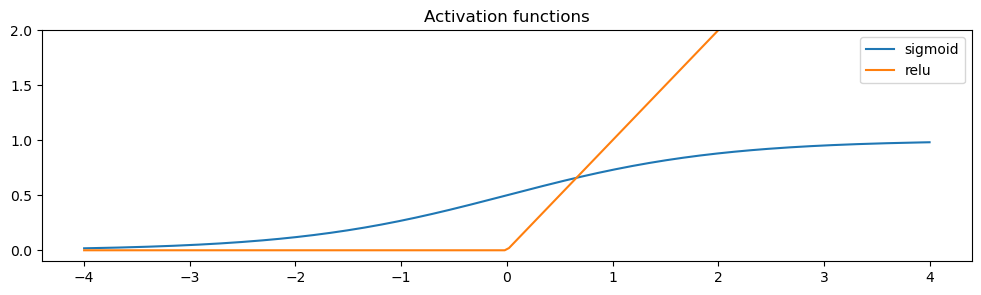

In [9]:
x = torch.linspace(-4, 4, 200)  # notice how similar the torch and numpy APIs are!
y_sigmoid = F.sigmoid(x)
y_relu = F.relu(x)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(x.numpy(), y_sigmoid.numpy(), label='sigmoid')
ax.plot(x.numpy(), y_relu.numpy(), label='relu')
ax.set_ylim(-0.1, 2)
ax.set_title('Activation functions')
ax.legend()
plt.show()

If you're curious to see more activation functions, [this table](https://en.wikipedia.org/wiki/Activation_function#:~:text=is%20often%20used.-,Table%20of%20activation%20functions,-%5Bedit%5D) is a good place to start.

Without activation functions, no matter how many layers we include in our MLP, and no matter how large those layers, the MLP will only ever be able to approximate linear relationships between the inputs and outputs. When we include these non-linear functions, however, it can be shown that MLPs are "universal function approximators." This means that an arbitrarily wide and deep MLP is able to approximate any function up to an arbitrarily small error.

Now that we have our basic components, let's construct our multi-layer perceptron. We'll start off really simple with only three layers. If we don't need anything more complicated than a simple, feed forward network, the [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) module is perfect. We can simply provide all of the layers we want, in order. Recall that our input has 12 channel and our output is a single channel cloud mask. Note that the output size of each layer must match the input size of the next layer. The activation functions don't need to know about sizes since they apply the same operation to each element.

In [10]:
in_channels = 12             # call this M
out_channels = 1             # call this N
simple_mlp_hidden_size = 16  # call this H

# define the MLP
simple_mlp = nn.Sequential(
    nn.Linear(in_channels, simple_mlp_hidden_size),             # M -> H
    nn.ReLU(),
    nn.Linear(simple_mlp_hidden_size, simple_mlp_hidden_size),  # H -> H
    nn.ReLU(),
    nn.Linear(simple_mlp_hidden_size, out_channels))            # H -> N

# Get some input from our training set, pass it through the model
for inp, valid, labels in train_loader:
    inp_flat = inp.view(-1, 12)  # flatten the input (our model treats each pixel as an independent observation
    inp_flat = inp_flat.float() / 255  # convert from uint8 to float
    preds = simple_mlp(inp_flat)  # applying a model to data is as simple as treating it as a function
    break

inp.shape, preds.shape

(torch.Size([16, 64, 64, 12]), torch.Size([65536, 1]))

You should see that the inputs are of size (BATCH_SIZE, 64, 64, 12), and the outputs are (BATCH_SIZE * 64 * 64, 1). Let's take a look at what our model spits out for this batch, with inputs on the left half, and the model's outputs on the right half:

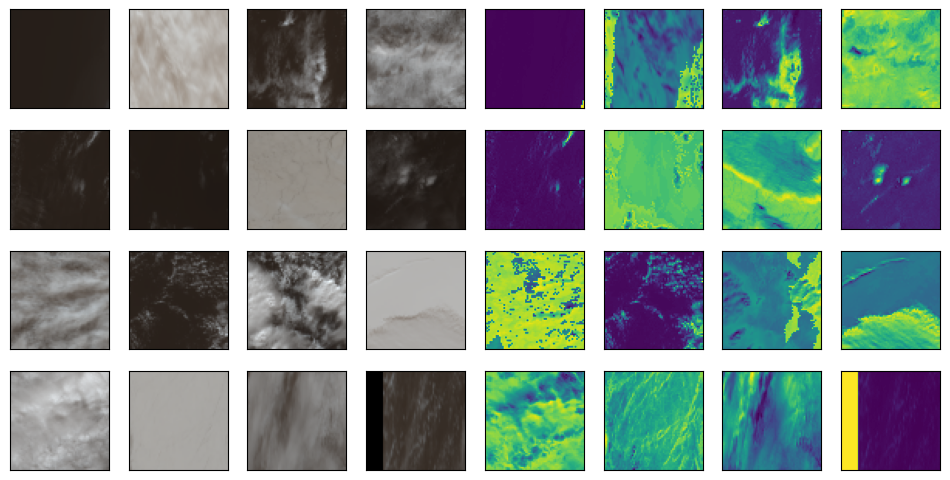

In [11]:
# need to be careful to use the validity mask
outp_img = torch.zeros((BATCH_SIZE, 64, 64))
outp_img[valid] = preds[valid.view(-1), 0]

fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i in range(16):
    # we have to convert from torch to numpy tensors, but first we have to detach it from the computation graph
    inp_img = inp[i, ..., :3].numpy()
    
    axs[i // 4][i % 4].imshow(inp_img)
    axs[i // 4][i % 4].set_xticks([])
    axs[i // 4][i % 4].set_yticks([])
    axs[i // 4][i % 4 + 4].imshow(outp_img[i].detach().numpy())
    axs[i // 4][i % 4 + 4].set_xticks([])
    axs[i // 4][i % 4 + 4].set_yticks([])
plt.subplots_adjust(wspace=None, hspace=None)
plt.show()

[back to top](#Contents)

## 6. Optimization

It doesn't seem like our model is doing much. Well, that makes sense, because we haven't trained it yet! Currently our model is full of random numbers and the output is likely to look pretty similar to a garbled version of the input. So... how do we train it to do better?

First, we need to decide what loss function (a.k.a. objective function) to use. This function will measure how wrong our model is, and we will optimize our model to minimize this function. Our task, cloud masking, is an example of classification (as opposed to regression). We are attempting to classify each pixel into one of two categories: cloud, or not cloud. Therefore, let's use the most typical loss function for classification tasks: the [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

Cross entropy is a measure of the difference between two probability distributions. Since our task only has two classes, we'll use the binary cross entropy loss. Normally, binary cross entropy loss expects our predictions to probabilities, and thus constrained to lie between 0 and 1. Our outputs are not probabilities, and are instead logits (they can take any value, and must be mapped to probabilities). Therefore, we will use the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

In [12]:
objective = torch.nn.BCEWithLogitsLoss()
loss = objective(preds[:, 0], labels.view(-1).float())
loss.item()

0.7043642997741699

Great! Now we know how "wrong" the model was. But what do we do with that? How do we use our loss function to _optimize_ our model?

Well, an optimizer of course! Neural networks are typically trained via gradient-based optimization. This means that we use our loss function to compute the gradient (vector version of a derivative) of each parameter in our network with respect to the loss. Since the entire forward process, including the linear layers, activation functions, and loss function, is _differentiable_, we can use the chain rule to determine the gradient of any parameter in our model. This process of going backwards through the network computing gradients is known as ["backpropagation."](https://en.wikipedia.org/wiki/Backpropagation)

These gradients give us the direction in which to nudge each parameter in order to lower the loss function. We can update each parameter with a step in that direction every time we see a new batch. We multiply the gradient with a hyperparameter called the "step size", alternatively referred to as the "learning rate". A larger step size will cause the model to update more quickly, but if it's too large, the model might keep overshooting the best location. A common practice is to gradually decrease the step size over the course of training.

If you were to compute the loss (and the gradient) for the entire dataset at once, then take an optimization step, then this technique would be known as "gradient descent." When we divide our data up into batches and take a step on each batch, it's known as "stochastic gradient descent" (SGD). This is because the loss/gradient is more erratic/random/stochastic with smaller batches. Still, SGD is typically better than gradient descent, as it's much faster: we don't have to iterate through our entire dataset each time we make an update. Also, a little bit of stochasticity can help to escape local minima during optimization.

Ok, well that sounds like a lot of math. We have to go back and compute all the gradients of every part of our forward pass, right? How do we implement this with code?

In [13]:
# first, define the optimizer, with a learning rate / step size of 0.1
optimizer = torch.optim.SGD(simple_mlp.parameters(), lr=0.1)

loss.backward()        # !!!
optimizer.step()       # update the parameters
optimizer.zero_grad()  # zero out the optimizer for next time (don't forget to do this!!!)

That was so easy! You might be asking, how does `loss.backward()` magically know all of the gradients of all of the functions we called several cells ago? Well, that's because torch has automatic differentiation built in. Torch functions will set up the backward pass as it computes the forward pass. Under the hood, torch will build a computation graph for the operations you use. [More details about autograd here.](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) This is also why torch arrays are called "tensors." A tensor is like an array, but its storage can also keep track of its gradient. Torch keeps the gradient computation hidden under the hood, and allows us to operate on tensors in almost exactly the same way as numpy arrays.

In practice, there are much better alternatives to SGD. A great default optimizer which will work fine in 99% of cases is called [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (no, that's not an acronym). For the rest of the tutorial we'll use Adam instead of SGD.

[back to top](#Contents)

## 7. A Minimal Training Loop

Let's put it all together. We'll loop over some batches, train our model, and take a look at what happens over time to the loss function. We won't run all the way through the training set, as that would take too long for demonstration purposes. Normally your model would loop over the training set multiple times, with each full pass of the training set called an "epoch." This should code should take a few minutes to run on the default value of `NUM_BATCHES=1000`.

While we run, we're going to track our training loss and training accuracy. Accuracy is simply the number of correctly classified pixels divided by the total number of pixels. At the end we'll display the loss, the running mean of the loss, and the accuracy in a plot.

In [14]:
BATCH_SIZE = 16
NUM_BATCHES = 1000
HIDDEN_SIZE = 32  # H

# re-initialize some stuff
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

in_channels = 12  # M
out_channels = 1  # N

# a bigger MLP
simple_mlp = nn.Sequential(
    nn.Linear(in_channels, HIDDEN_SIZE),   # M -> H
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),   # H -> H
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),   # H -> H
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),   # H -> H
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),   # H -> H
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, out_channels))  # H -> N
objective = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(simple_mlp.parameters())  # can use Adam with the default parameters

losses = []
accs = []
nums_valid = []

for batch_idx, (inp, valid, labels) in tqdm(enumerate(train_loader), total=NUM_BATCHES):
    # only run on NUM_BATCHES batches
    if batch_idx >= NUM_BATCHES:
        break

    # convert from uint8 to float32
    inp = inp.float() / 255
    
    preds = simple_mlp(inp[valid])                        # get model predictions on valid inputs 
    loss = objective(preds[:, 0], labels[valid].float())  # compute the loss function
    optimizer.zero_grad()                                 # zero out the optimizer
    loss.backward()                                       # backwards pass
    optimizer.step()                                      # update the model
    losses.append(loss.item())                            # keep track of the loss over time

    # compute and track accuracy over time (need to track num valid pixels to correctly compute the average later)
    num_valid = valid.sum()
    accs.append((((preds[..., 0] > 0) == labels[valid]).sum() / num_valid).item())
    nums_valid.append(num_valid.item())

# compute the running mean of the losses so far
running_loss_mean = np.array(losses).cumsum() / (np.arange(len(losses)) + 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

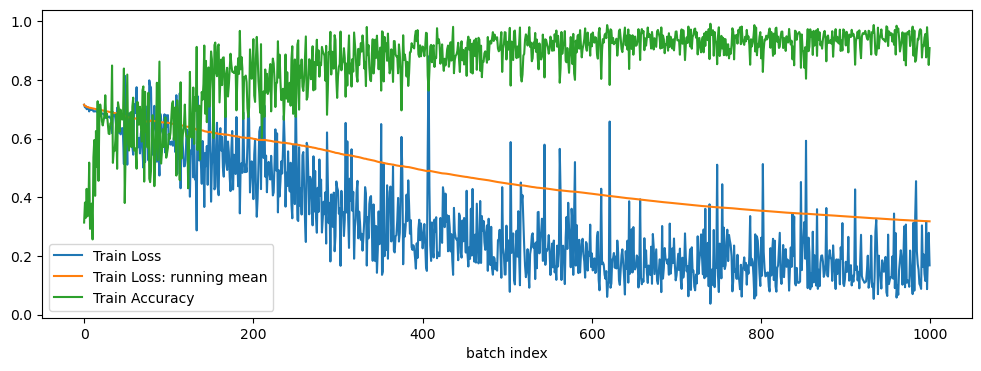

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(losses)), np.array(losses), label='Train Loss')
plt.plot(np.arange(len(losses)), running_loss_mean, label='Train Loss: running mean')
plt.plot(np.arange(len(accs)), accs, label='Train Accuracy')
plt.legend()
plt.xlabel('batch index')
plt.show()

You should be seeing that the training loss goes down, while the accuracy goes up. That's what we want. The model's skill seems to plateau very quickly, and it seems like our accuracy is quite high! Unfortunately, this is a little misleading. Let's take a qualitative look at some examples to see why:

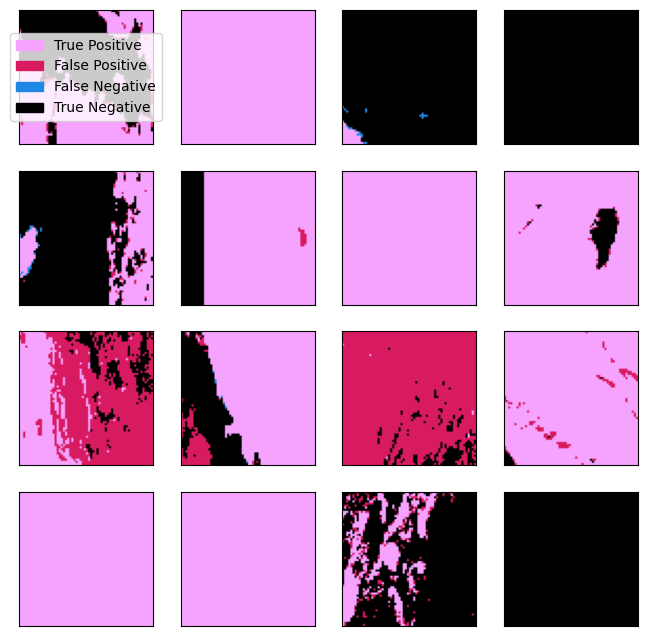

In [16]:
for inp, valid, labels in train_loader:
    preds = simple_mlp(inp[valid].float() / 255)
    break

preds_img = torch.zeros((BATCH_SIZE, 64, 64)).bool()
preds_img[valid] = preds[..., 0] > 0  # we have to threshold our output logits to turn them into a mask

color1 = np.array([216, 27, 96])
color2 = np.array([30, 136, 229])

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    viz_img = np.zeros((64, 64, 3))
    viz_img = np.clip(preds_img[i].numpy()[..., None] * color1[None, None] + \
                      labels[i].numpy()[..., None] * color2[None, None], 0, 255)
    axs[i // 4][i % 4].imshow(viz_img)
    axs[i // 4][i % 4].set_xticks([])
    axs[i // 4][i % 4].set_yticks([])
legend_elements = [Patch(facecolor=np.clip(color1 + color2, 0, 255) / 255,
                         edgecolor=np.clip(color1 + color2, 0, 255) / 255,
                         label='True Positive'),
                   Patch(facecolor=color1 / 255, edgecolor=color1 / 255, label='False Positive'),
                   Patch(facecolor=color2 / 255, edgecolor=color2 / 255, label='False Negative'),
                   Patch(facecolor=np.array([0, 0, 0]), edgecolor=np.array([0, 0, 0]), label='True Negative')]
axs[0][0].legend(handles=legend_elements, loc='center')
plt.subplots_adjust(wspace=None, hspace=None)
plt.show()

If you want to check out more examples, you can rerun the cell to get a new batch every time.

You might notice some problems with our predictions. You might see quite a few examples of the model misclassifying small clouds. Large clouds will dominate the data, and the model can achieve a high accuracy without accurately masking these smaller clouds. You might even see occasional images where the model is totally wrong - predicting all cloud or all no-cloud when the scene is actually partly cloudy. We can do better!

[back to top](#Contents)

## 8. Running on GPU / CUDA

Until now, all the code we've run has been on just the central processing unit (CPU). This has restricted the capacity of neural network we can effectively train. During training, we need memory for the model's parameters, the gradient of those parameters, and for the intermediate tensors computed along the forward and backward passes. If we were to use too big of a network or too big of a batch size, we'd run out of memory. You may have noticed this if you tried increasing the batch size and your notebook crashed as a result.

In practice, machine learning algorithms make use of graphics processing units (GPUs), which are much more effective at highly parallel operations than CPUs. NVIDIA has a software layer called CUDA which allows the use of GPUs for general purpose computing, including large matrix multiplications, which is essentially all that our neural network training is doing. Pytorch pairs tightly with CUDA, making it very simple to adapt your code to leverage the GPU.

<div class="alert alert-info" role="alert">
NOTE: To continue on in this notebook, your instance must be running on the "NVIDIA Tesla T4, ~16 GB, ~4 CPUs" instance type, otherwise you won't have a GPU to use. We do not give participants access to this instance type, by default. This is to prevent excessive costs, as GPU-hours can be expensive. We want to avoid unnecessary usage of these GPU-hours by users who did not intend or need to use them. If you are using this notebook as a participant of the PACE Hackweek, and would like access to a GPU, please come find Sean Foley for assistance.
</div>

If you're unsure about whether you're currently running in an instance with a GPU, you can easily check if CUDA is available from torch with the following:

In [17]:
torch.cuda.is_available()

False

<div class="alert alert-warning" role="alert">

The remaining cells in this notebook are set to "Raw" cell type, to prevent errors from attempting to run without CUDA. Change them to "Code" if CUDA is available.

</div>

So, now that we've ensured you have access to a GPU via CUDA, how do we convert our code to use CUDA? Well, converting a single torch tensor to CUDA is as easy as adding `.cuda()` after it. We can also convert our model with `.cuda()`. Another way to move a tensor between devices is to use the `.to(device=...)` syntax, which allows you to be a little smarter with your allocation, especially in cases where you're using multiple GPUs at the same time. The following cell illustrates the basic functionality:

[back to top](#Contents)

## 9. Convolutional Neural Networks

Our simple MLP has a big problem: it operates independently on every pixel. This means it is incapable of incorporating any _spatial context_ into its understanding of a scene. But we know that adjacent pixels are _not_ independent, and that spatial context is likely to be useful. For example, a pixel is more likely to be cloudy if many of its neighbors are cloudy. On the other hand, if a scene contains reflective surfaces (like snow and ice), then bright values might be less likely to imply that a pixel is cloudy. By allowing our network to operate on an entire image at once, we allow it to model this context.

But now we have a different problem. If we were to use our simple MLP model from above on an entire image, it would mean that, instead of 12 inputs, each instance would have $12 \times 64 \times 64 = 49152$ inputs. And our images are pretty small. You can easily imagine how crazy this would get for a $1000\times1000$ image, or even a 4K image. Not only will this be really slow, but it also means that our network will have to learn _extremely redundant_ features, because it will have to re-learn what a cloud looks like _in every pixel of the image_.

We can fix this, but first let's take a brief tangent and talk about convolution. Convolution is an operation on two functions that produces a third function.  You can think of convolution as the multiplication of two functions as we slide one function across the other. Formally, the convolution of two continuous signals $f$ and $g$ is defined as:

$f * g(t) = \int_{-\inf}^{\inf}f(\tau)g(t-\tau)d\tau$

The [wikipedia article](https://en.wikipedia.org/wiki/Convolution) is a great resource to further understand convolution, but we've also provided you an example of (discrete) convolution below:

Convolution generalizes to multiple dimensions. Two-dimensional convolution is extremely useful for image processing. [This graphic](https://en.wikipedia.org/wiki/Convolution#/media/File:2D_Convolution_Animation.gif) is a great visualization of how it works. Its as simple as multiplying where our kernel overlaps our image and summing the values, then repeating that in a sliding window fashion across the whole image.

We can convolve an image with different "kernels" or "filters" to achieve specific effects on the image. For example, the 2D normal (Gaussian) distribution is useful for [blurring an image](https://en.wikipedia.org/wiki/Gaussian_blur). The standard deviation of the Gaussian will determine the strength of the blur. Another useful filter is the [Sobel filter](https://en.wikipedia.org/wiki/Sobel_operator) which is useful for extracting information about the edges in an image.

Below you'll see what happens when we apply these filters to an image of a checkerboard. You can mostly ignore the code in this next cell (unless you're curious), but pay attention to the plots.

You can see how with some very simple kernels, we are able to achieve interesting transformations of the input image. Hopefully you can imagine how, with a variety of kernels, you could extract quite a lot of useful information out of an image.

A convolutional neural network is composed of multiple layers, where each layer is represented by convolutional kernels that are applied to the inputs with this same sliding window process. Unlike the simple examples shown above, a convolutional layer usually has multiple input and output channels. You can think of convolutional layers as being fully connected in the _channel dimension_, and convolutional in the _spatial dimensions_. The [documentation on `torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) is helpful if you want more details.

There are a few more important points about 2D convs to keep in mind:
- Convolutional layers should still be separated by non-linear activation functions, or you'll end up with the same reduction-to-linearity problem described earlier.
- CNNs almost always use 3x3 kernels, as stacking multiple 3x3 layers works better than using one layer with a larger kernel dimension
- There is still an optional (but typically used) bias term in convolutional layers, just like in linear layers
- A convolutional layer will slightly crop the input image (by kernel_size - 1) unless you apply padding to the input

Now, let's design a simple CNN. Instead of using `torch.nn.Sequential`, we'll create a class that implements `torch.nn.Module`, which gives us more fine-grained control over the design of our model. To do this, we only have to implement `__init__` and `forward`, which gets called when you apply the model to some input. We'll start with only 10 layers, which are all 3x3 kernels with an intermediate feature depth of 16. We'll set padding to 1 to avoid shrinking the image dimensions at the boundaries. Using 10 layers is a good starting point - if we used too many layers we'd have to start thinking more carefully about how the gradients propagate through those layers (see the [ResNet paper](https://arxiv.org/abs/1512.03385) if you'd like to know more).

You'll notice we're also adding our ReLU activations, like before, and also batch normalization layers. The original [batchnorm paper](https://arxiv.org/abs/1502.03167) is a good read, but the TL;DR is that it will make our training faster.

[back to top](#Contents)

## 10. Putting It All Together

Now we can put it all together to train our CNN on the same data! We can crank the batch size way up and see what changes. Feel free to try bigger models. The GPU on this instance can handle much heavier loads than we are currently putting it through. Try playing around with these settings and see what you learn!

You'll also probably notice that this script isn't that much faster than the CPU-only training from above. The data loading is currently the bottleneck. This is very often the case in practice.

[back to top](#Contents)

## 11. Want More?

This notebook is already massive, although there are many more topics we wish we could cover. If you'd like to continue your learning journey, we have some suggestions for you:
- learn about [data augmentation](https://pytorch.org/vision/stable/transforms.html) to get more bang for your buck out of your training data
- we're only scratching the surface of designing CNNs. In fact, the CNN in this notebook is pretty hastily designed. Here are some more concepts to explore:
    - Skip connections if you want to build deeper networks
    - Max pooling or average pooling layers
    - Receptive field and effective receptive field
- see [this post](https://discuss.pytorch.org/t/how-to-prefetch-data-when-processing-with-gpu/548/19) for some common ideas on how to speed up data loading
- check out [transformers](https://arxiv.org/abs/1706.03762) and [vision transformers](https://arxiv.org/abs/2010.11929) for a newer, fancier alternative to CNNs
- play around with [tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) to track your model's progress in real time

[back to top](#Contents)